Note: Using the optimal sigma value from the coarser mesh for each eigenvalue

Monolayer unit domain. Piecewise PML. Convergence (eigenvalue error)

In [17]:
try:
    import dolfinx
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-release-complex.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx

In [18]:
import matplotlib.pyplot as plt

try:
	if "science" not in plt.style.available:
		try:
			import scienceplots  # registers styles if installed
		except Exception:
			# Install SciencePlots (registers the 'science' style) and import it
			get_ipython().run_line_magic('pip', 'install -q SciencePlots')
			import scienceplots  # noqa: F401
	plt.style.use(["science", "grid"])
except Exception as e:
	# If anything fails, fall back to a commonly available style
	print("Warning: 'science' style not available. Using 'seaborn' instead. Error:", e)
	plt.style.use("seaborn")

In [19]:
import matplotlib as mpl
colors_list = [
    "#0C5DA5",  # blue
    "#00B945",  # green
    "#FF9500",  # orange
    "#FF2C00",  # red
    "#845B97",  # purple
    "#474747",  # dark gray
    "#9e9e9e",  # light gray
]

mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=colors_list)

mpl.rcParams.update({
    # Tamaño físico
    "figure.figsize": (2.9, 2.6),

    # Líneas
    "lines.linewidth": 2.0,
    "lines.markersize": 8,

    # Fuente de títulos, labels y leyendas
    "font.size": 23,
    "axes.labelsize": 23,
    "axes.titlesize": 23,
    "legend.fontsize": 20,

    # Números de los ejes un pelín más pequeños
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,

    # Ejes y ticks
    "axes.linewidth": 1.4,
    "xtick.major.width": 1.4,
    "ytick.major.width": 1.4,

    # PDF limpio
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})


In [20]:
# Importing libraries
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from mpi4py import MPI
from ufl import (
    inner,
    grad,
    conj,
    TrialFunction,
    TestFunction,
    as_matrix,
    as_vector,
    dot,
    Or,
    Measure,
    conditional,
    SpatialCoordinate,
)
from dolfinx.mesh import locate_entities_boundary, create_interval, locate_entities, meshtags, create_submesh
from dolfinx.fem import FunctionSpace, Function, functionspace, Function, dirichletbc, locate_dofs_topological, petsc, form, assemble_matrix
import basix
from petsc4py.PETSc import ScalarType, KSP
from slepc4py.SLEPc import EPS  


Domain, PML, refinement and physical configurations

In [21]:
# Define element size for the mesh refinement
h_i = [ 0.0625,      #N=1
        0.0625 / 2,  #N=2
        0.0625 / 4,  #N=3
        0.0625 / 8,  #N=4
        0.0625 / 16] #N=5


# Domain configuration
Lx = 1. # fluid domain length (without PML)
l_inner=Lx/2

# Physical configuration
rho_media_1 = 1. # kg/m^3 
vel_media_1 = 2.   # m/s
rho_media_2 = 1. # kg/m^3 
vel_media_2 = 1.   # m/s

# Define the density and velocity functions  
def rho_function(x):    
    return np.where(x[0] > l_inner, rho_media_2,rho_media_1)

def vel_function(x):    
    return np.where(x[0] > l_inner, vel_media_2,vel_media_1)
 
# PML configuration
pml_thickness = Lx/4

degree=[2,1]
# Solver configuration

requested_eigenvalues_number = 50 # Number of eigenvalues to compute

Solver configuration and computing

In [22]:
def get_configured_problem(mesh, degrees, sigma_x, target):
    # Initialize dictionaries
    dof = {}
    solver_dict={}
    V_dict={}
    Q_dict={}

    # Define finite element spaces
    p_fe_type = basix.ufl.element(family="Lagrange", cell=mesh.basix_cell(), degree=degrees[0])
    v_fe_type = basix.ufl.element(family="DG", cell=mesh.basix_cell(), degree=degrees[1], shape=(mesh.geometry.dim,))
    FE = {"p": p_fe_type, "v": v_fe_type}

    # Create a submesh of PML associated cells
    tdim = mesh.topology.dim

    # Identify the fluid cells
    # fluid_cells = locate_entities(mesh, tdim, lambda x: x[0] <= Lx)

    # Create function spaces for mesh and submesh
    Q = functionspace(mesh,FE["p"])
    V = functionspace(mesh, FE["v"])

    # Dictionaries to store the number of dofs
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global

    # Boundary conditions application (for pressure)
    bc = []
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], 0.0))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs))

    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], Lx+pml_thickness))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Define the subdomains using a Python function
    TOL = 1e-6
    def pml_domain(x):
        """Returns True for points in (Lx, Lx + pml_thickness]"""
        return x[0] > Lx - TOL

    # Get topology dimension
    tdim = mesh.topology.dim

    # Locate cells in each subdomain
    pml_cells = locate_entities(mesh, tdim, pml_domain)

    # Create a meshtag to mark the subdomains
    num_cells = mesh.topology.index_map(tdim).size_local
    cell_markers = np.ones(num_cells, dtype=np.int32) # Physical domain tag=1
    cell_markers[pml_cells] = 2       # PML domain tag=2

    cell_tags = meshtags(mesh, tdim, np.arange(num_cells, dtype=np.int32), cell_markers)

    # Now you can use these tags for integration measures
    dx = Measure("dx", domain=mesh, subdomain_data=cell_tags)

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs))

    # Interpolates the density and velocity functions
    W = functionspace(mesh, ("DG", 0))
    rho = Function(W)
    rho.interpolate(rho_function)
    c = Function(W)
    c.interpolate(vel_function)

    # Spatial Coordinate is updated for the actual mesh
    x = SpatialCoordinate(mesh)

    # Variation formulation definition
    p = TrialFunction(Q)
    v = TrialFunction(V)
    q = TestFunction(Q)
    w = TestFunction(V)

    # Define the variational forms
    a = form(
        [
            [sigma_x(x) / (rho * c**2) * p * conj(q) * dx(2), -1 * inner(v, grad(q)) * dx],
            [inner(grad(p), w) * dx, sigma_x(x) * rho * inner(v, w) * dx(2)],
        ]
    )
    b = form(
        [
            [1.0 / (rho * c**2) * p * conj(q) * dx, None],
            [None, rho * inner(v, w) * dx],
        ]
    )
    # Assemble matrices
    A = petsc.assemble_matrix_block(a, bcs=bc)
    A.assemble()
    B = petsc.assemble_matrix_block(b, bcs=bc)
    B.assemble()

    # SLEPc solver configuration for linear eigenvalue problem (A x =\lambda x B)
    solver = EPS().create()
    solver.setOperators(-A, B)
    solver.setType("arnoldi")
    solver.setWhichEigenpairs(9)  # TARGET_IMAGINARY = 9, TARGET_MAGNITUDE = 7, TARGET_REAL = 8
    solver.setDimensions(
        requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
    )
    solver.setTolerances(1e-16, 100)
    st = solver.getST()
    st.setType("sinvert")  # Applying spectral transformation "shift and invert"
    solver.setTarget(target)
    solver.solve()
    n_eigs_converged_quadratic = solver.getConverged()

    return solver, mesh, Q, V, dof

Approx eigenvalues calculation

In [23]:
def get_exact_eigenvalue(n):
    # Exact eigenvalues for the problem
    exact_physical_eigs_function= lambda n: vel_media_1 / l_inner * np.arctan(-1j * (vel_media_2 * rho_media_2) / (vel_media_1 * rho_media_1))+ n * np.pi * vel_media_1 / l_inner
    return exact_physical_eigs_function(n)

piecewise

In [24]:
def get_closest_eigenpair(solver, omega_target, verbose=False):
    """
    Devuelve el autovalor y autovector más cercano a omega_target
    usando distancia compleja |λ - λ_target|, sin usar get_approx_eigenpair.

    Returns
    -------
    lambda_best : complex
    x_best : PETSc.Vec (copia del autovector)
    idx_best : int (índice raw en solver)
    """

    # Número de modos convergidos
    nconv = solver.getConverged()
    if nconv == 0:
        raise RuntimeError("No hay autovalores convergidos")

    # Vector temporal para extraer Eigenpairs
    vr, vi = solver.getOperators()[0].getVecs()

    best = None

    for k in range(nconv):
        lam = solver.getEigenpair(k, vr) * 1j   # igual que tú haces

        dist = abs(lam - omega_target)          # distancia COMPLEJA correcta

        if best is None or dist < best[2]:
            best = (lam, k, dist)

    lam_best, idx_best, dist_best = best

    # Obtener el autovector correspondiente
    solver.getEigenpair(idx_best, vr)  # vr = autovector del modo idx_best
    x_best = vr.copy()                 # hacemos copia

    if verbose:
        print(f"[Closest] idx={idx_best}  λ={lam_best}  dist={dist_best}")

    return lam_best, idx_best


In [25]:
target=[-12j,0,0, -50j]

In [26]:
exact = {
    0: get_exact_eigenvalue(1),
    3: get_exact_eigenvalue(4)
}


def compute_physical_eigs(
        sigma_opt: dict,
        sigma_update_fn,
    ):
    """
    Computa autovalores aproximados coa PML por tramos para cada h e cada modo.

    Parámetros
    ----------
    sigma_opt : dict
        Valores óptimos de sigma para cada modo {j: sigma_j}.
    sigma_update_fn : función
        Función *callable* que recibe (x, sigma_j) e devolve sigma(x).
        Exemplo esperado: lambda x, s: conditional(x[0] > Lx, s, 0.0)
    """

    # matriz [len(h_i)] x [max_index+1]
    max_j = max(exact.keys())
    approx_piecewise = [
        [0 for _ in range(max_j + 1)]
        for _ in range(len(h_i))
    ]

    # Bucle sobre modos (0,3 no teu caso)
    for j in exact.keys():
        for i, h in enumerate(h_i):

            # sigma(x) por tramos, usando a función pasada polo usuario
            sigma_x = lambda x, j=j: sigma_update_fn(x, sigma_opt[j])


            # malla
            mesh = create_interval(
                MPI.COMM_WORLD,
                int((Lx + pml_thickness) / h),
                [0, Lx + pml_thickness]
            )
            # print(f"Modo {j}: sigma_opt = {sigma_opt[j]}")
            # print("sigma_x UFL:", sigma_x(SpatialCoordinate(mesh)))

            # solver do problema
            solver, mesh, Q, V, dof = get_configured_problem(
                mesh, degree, sigma_x, target[j]
            )

            [approx_val, index]=get_closest_eigenpair(solver, exact[j])
            approx_piecewise[i][j] = approx_val

    # Agora extraemos listas por cada modo
    rel_error = {}

    for j in exact.keys():
        approx_j = [row[j] for row in approx_piecewise]
        rel_error[j] = np.abs(approx_j - exact[j]) / np.abs(exact[j])*100

    return approx_piecewise, rel_error


In [27]:
#[P2, P1] pml_th=Lx/4
sigma_opt_piecewise={0: 26., 3: 2.95}    #  óptimo para P2,P1, N=1 omega_0
sigma_opt_quadratic={0: 223.87, 3: 47.31} #  óptimo para P2,P1, N=1 omega_0
sigma_opt_singular={0: 1.0, 3: 1.0} #  óptimo sempre 1

sigma_piecewise=lambda x, sigma_opt: sigma_opt
sigma_quadratic=lambda x, sigma_opt: sigma_opt*(x[0]-Lx)**2/(pml_thickness**2)
sigma_singular=lambda x, sigma_opt: sigma_opt/(Lx+pml_thickness-x[0])


In [28]:
[approx_piecewise, rel_error_piecewise]=compute_physical_eigs(sigma_opt_piecewise,sigma_piecewise)
[approx_quadratic, rel_error_quadratic]=compute_physical_eigs(sigma_opt_quadratic,sigma_quadratic)
[approx_singular, rel_error_singular]=compute_physical_eigs(sigma_opt_singular,sigma_singular)

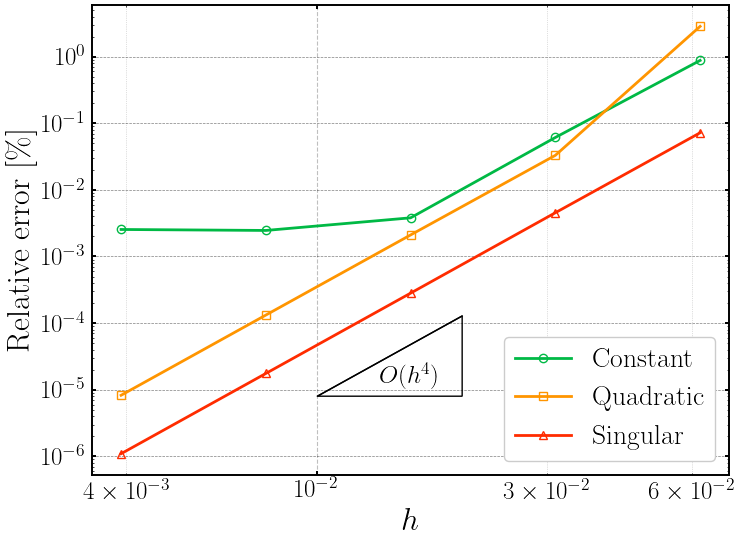

In [48]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mticker
from matplotlib.patches import Polygon
from matplotlib.ticker import FuncFormatter


fig, ax = plt.subplots(figsize=(8, 6))

lw = 2.0
ms = 6

# piecewise
ax.plot(h_i, rel_error_piecewise[0], "o-", mfc='none', lw=lw, ms=ms,
        color=colors_list[1], label="Constant")

# quadratic
ax.plot(h_i, rel_error_quadratic[0], "s-", mfc='none', lw=lw, ms=ms,
        color=colors_list[2], label="Quadratic")

# singular
ax.plot(h_i, rel_error_singular[0], "^-", mfc='none', lw=lw, ms=ms,
        color=colors_list[3], label="Singular")



ax.set_xscale("log")
ax.set_yscale("log")
ax.xaxis.set_major_locator(mticker.LogLocator(base=10.0, numticks=10))
ax.xaxis.set_minor_locator(
    mticker.LogLocator(base=10.0, subs=(2,3,4,5,6,7,8,9), numticks=100)
)

ax.xaxis.set_major_formatter(mticker.LogFormatterMathtext())# Grid: líneas verticales en ticks mayores y menores
ax.grid(which='major', axis='x', linestyle='--', color='gray', linewidth=0.8)
ax.grid(which='minor', axis='x', linestyle=':', color='gray', linewidth=0.5)  # menores más finas

# Punto del ángulo recto (arriba izquierda)
x0 = 2e-2
y0 = 8e-6

dx = 2.0      # factor horizontal
order = 4     # O(h^4)

# Vértices:
# A = ángulo recto (arriba izquierda)
# B = derecha (horizontal)
# C = abajo (vertical)
triangle = np.array([
    [x0, y0],                       # A: ángulo recto (abaixo dereita)
    [x0/dx, y0],                    # B: esquerda (horizontal)
    [x0, y0*(dx**order)]            # C: arriba (vertical)
])

poly = Polygon(triangle, fill=False, edgecolor="k", lw=1)
ax.add_patch(poly)

# Hipotenusa (opcional remarcarla)
ax.plot(
    [x0/dx, x0],
    [y0, y0*(dx**order)],
    color="k", lw=1
)

ax.text(
    x0*0.9,
   1.5e-1*y0*(dx**order/1.5),
    r"$O(h^4)$",
    fontsize=18,
    ha="right"
)
ax.grid(True)
ax.set_xlabel(r"$h$")
ax.set_ylabel("Relative error [\%]")
# ax.set_title(r"Converxencia modo $\omega_0$")
# definir minor ticks
# minor ticks onde queres etiqueta
minor_ticks = [4e-3,3e-2, 6e-2]
ax.set_xticks(minor_ticks, minor=True)

def minor_formatter(x, pos):
    if x == 0:
        return ''
    exp = int(np.floor(np.log10(abs(x))))
    mant = x / 10**exp
    return rf'${mant:g}\times10^{{{exp}}}$'

ax.xaxis.set_minor_formatter(FuncFormatter(minor_formatter))
ax.tick_params(axis='x', which='minor')
ax.legend(loc="lower right")
plt.tight_layout()

plt.savefig("1D_bicapa_convergencia_omega0.pdf", bbox_inches="tight")


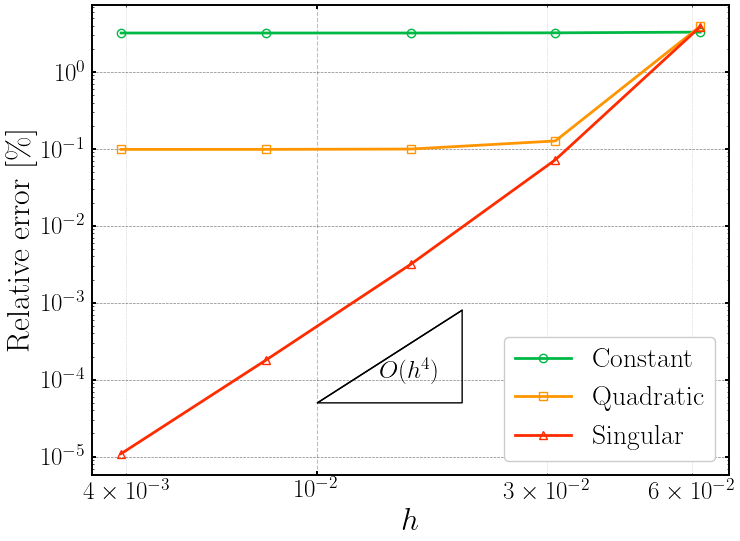

In [49]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mticker
from matplotlib.patches import Polygon


fig, ax = plt.subplots(figsize=(8, 6))

lw = 2.0
ms = 6

# piecewise
ax.plot(h_i, rel_error_piecewise[3], "o-", mfc='none', lw=lw, ms=ms,
        color=colors_list[1], label="Constant")

# quadratic
ax.plot(h_i, rel_error_quadratic[3], "s-", mfc='none', lw=lw, ms=ms,
        color=colors_list[2], label="Quadratic")

# singular
ax.plot(h_i, rel_error_singular[3], "^-", mfc='none', lw=lw, ms=ms,
        color=colors_list[3], label="Singular")



ax.set_xscale("log")
ax.set_yscale("log")
ax.xaxis.set_major_locator(mticker.LogLocator(base=10.0, numticks=10))
ax.xaxis.set_minor_locator(
    mticker.LogLocator(base=10.0, subs=(2,3,4,5,6,7,8,9), numticks=100)
)

ax.xaxis.set_major_formatter(mticker.LogFormatterMathtext())# Grid: líneas verticales en ticks mayores y menores
ax.grid(which='major', axis='x', linestyle='--', color='gray', linewidth=0.8)
ax.grid(which='minor', axis='x', linestyle=':', color='gray', linewidth=0.5)  # menores más finas

# Punto del ángulo recto (arriba izquierda)
x0 = 2e-2
y0 = 5e-5

dx = 2.0      # factor horizontal
order = 4     # O(h^4)

# Vértices:
# A = ángulo recto (arriba izquierda)
# B = derecha (horizontal)
# C = abajo (vertical)
triangle = np.array([
    [x0, y0],                       # A: ángulo recto (abaixo dereita)
    [x0/dx, y0],                    # B: esquerda (horizontal)
    [x0, y0*(dx**order)]            # C: arriba (vertical)
])

poly = Polygon(triangle, fill=False, edgecolor="k", lw=1)
ax.add_patch(poly)

# Hipotenusa (opcional remarcarla)
ax.plot(
    [x0/dx, x0],
    [y0, y0*(dx**order)],
    color="k", lw=1
)

ax.text(
    x0*0.9,
   2e-1*y0*(dx**order/1.5),
    r"$O(h^4)$",
    fontsize=18,
    ha="right"
)
ax.grid(True)
ax.set_xlabel(r"$h$")
ax.set_ylabel("Relative error [\%]")
# ax.set_title(r"Converxencia modo $\omega_3$")
# definir minor ticks
# minor ticks onde queres etiqueta
minor_ticks = [4e-3,3e-2, 6e-2]
ax.set_xticks(minor_ticks, minor=True)

def minor_formatter(x, pos):
    if x == 0:
        return ''
    exp = int(np.floor(np.log10(abs(x))))
    mant = x / 10**exp
    return rf'${mant:g}\times10^{{{exp}}}$'

ax.xaxis.set_minor_formatter(FuncFormatter(minor_formatter))
ax.legend(loc="lower right")
plt.tight_layout()

plt.savefig("1D_bicapa_convergencia_omega3.pdf", bbox_inches="tight")
